In [51]:
import time
import scipy.sparse as sp
import numpy as np
import pandas as pd
from scipy.sparse.linalg import svds
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import dask.dataframe as dd
import matplotlib.pyplot as plt
%matplotlib inline

In [52]:
data = dd.read_csv('recommendations.csv')
data.head()

,director_name,num_critic_for_reviews,duration,genres,movie_title,num_voted_users,num_user_for_reviews,language,country,budget,title_year,imdb_score,rating_x,movieId,userId,rating_y
0,James Cameron,723.0,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,3054.0,English,USA,237000000.0,2009,7.9,Good,72998,31,4.5
1,James Cameron,723.0,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,3054.0,English,USA,237000000.0,2009,7.9,Good,72998,65,3.5
2,James Cameron,723.0,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,3054.0,English,USA,237000000.0,2009,7.9,Good,72998,82,2.5
3,James Cameron,723.0,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,3054.0,English,USA,237000000.0,2009,7.9,Good,72998,96,3.5
4,James Cameron,723.0,178.0,Action|Adventure|Fantasy|Sci-Fi,Avatar,886204,3054.0,English,USA,237000000.0,2009,7.9,Good,72998,98,4.0


In [13]:
data['userId'] = data['userId'].astype(int)
data['movieId'] = data['movieId'].astype(int)

ratings = data[['userId', 'movieId', 'rating_y']].values

n_users = int(np.max(ratings[:, 0])) + 1
n_movies = int(np.max(ratings[:, 1])) + 1

R = sp.coo_matrix((ratings[:, 2], (ratings[:, 0], ratings[:, 1])), shape=(n_users, n_movies)).tocsr()

print(f"Sparse matrix shape: {R.shape}")

R_dense_preview = R[:10, :10].toarray()
print("Dense preview of the sparse matrix (first 10 rows and 10 columns):")
print(R_dense_preview)

def print_sparse_matrix_preview(sparse_matrix, n=10):
    rows, cols = sparse_matrix.nonzero()
    for i in range(min(n, len(rows))):
        print(f"Row {rows[i]}, Col {cols[i]}: {sparse_matrix[rows[i], cols[i]]}")

print("Non-zero entries of the sparse matrix (first 10 non-zero entries):")
print_sparse_matrix_preview(R, n=10)

Sparse matrix shape: (138494, 131014)
Dense preview of the sparse matrix (first 10 rows and 10 columns):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 5. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 4. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Non-zero entries of the sparse matrix (first 10 non-zero entries):
Row 1, Col 151: 4.0
Row 1, Col 223: 4.0
Row 1, Col 253: 4.0
Row 1, Col 260: 4.0
Row 1, Col 296: 4.0
Row 1, Col 337: 3.5
Row 1, Col 541: 4.0
Row 1, Col 589: 3.5
Row 1, Col 924: 3.5
Row 1, Col 1036: 4.0


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(ratings)

# Initialize a PCA object with 2 components
pca = PCA(n_components=2)

# Apply PCA to the scaled data
projected_X = pca.fit_transform(X_scaled)

# Print the projected data's shape and the top 2 eigenvectors
print(projected_X.shape)
print(pca.components_)

(10084831, 3)
[[-0.1846578   0.72320229  0.66549226]
 [ 0.91408105 -0.1223782   0.38662567]
 [ 0.36105031  0.67970731 -0.63846742]]


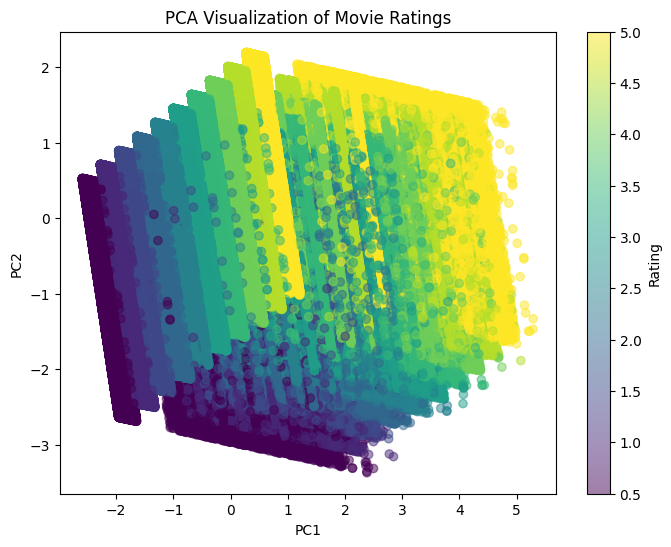

In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(x=projected_X[:, 0], y=projected_X[:, 1], c=data['rating_y'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Rating')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Visualization of Movie Ratings')
plt.show()

In [54]:
data.columns

Index(['director_name', 'num_critic_for_reviews', 'duration', 'genres',
       'movie_title', 'num_voted_users', 'num_user_for_reviews', 'language',
       'country', 'budget', 'title_year', 'imdb_score', 'rating_x', 'movieId',
       'userId', 'rating_y'],
      dtype='object')

In [64]:
# data = data.groupby(['userId', 'movie_title'], index=False)['rating_y'].mean()
grouped_data = data.groupby(['userId', 'movie_title'])['rating_y'].mean().reset_index()


In [58]:
data.shape

(<dask_expr.expr.Scalar: expr=(ResetIndex(frame=((ReadCSV(96ecb21)[['movie_title', 'userId', 'rating_y']]).mean(observed=False, chunk_kwargs={'numeric_only': False}, aggregate_kwargs={'numeric_only': False}, _slice='rating_y'))['rating_y'])).size() // 3, dtype=int32>,
 3)

In [65]:
grouped_data['movie_title'] = grouped_data['movie_title'].astype('category')

In [67]:
from sklearn.preprocessing import StandardScaler

numeric_data = grouped_data[['userId', 'rating_y']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

print(scaled_data)

[[-1.72427887 -0.02547452]
 [-1.72427887  0.45277827]
 [-1.72427887  0.45277827]
 ...
 [ 1.73712165  1.40928385]
 [ 1.73712165  0.93103106]
 [ 1.73712165  1.40928385]]


In [68]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

print(pca_result)

[[-1.23726249  1.20123608]
 [-0.8990867   1.53941187]
 [-0.8990867   1.53941187]
 ...
 [ 2.22484467 -0.23181633]
 [ 1.88666888 -0.56999212]
 [ 2.22484467 -0.23181633]]


In [69]:
scaled_data.shape

(9806754, 2)

In [70]:
pca_result.shape

(9806754, 2)

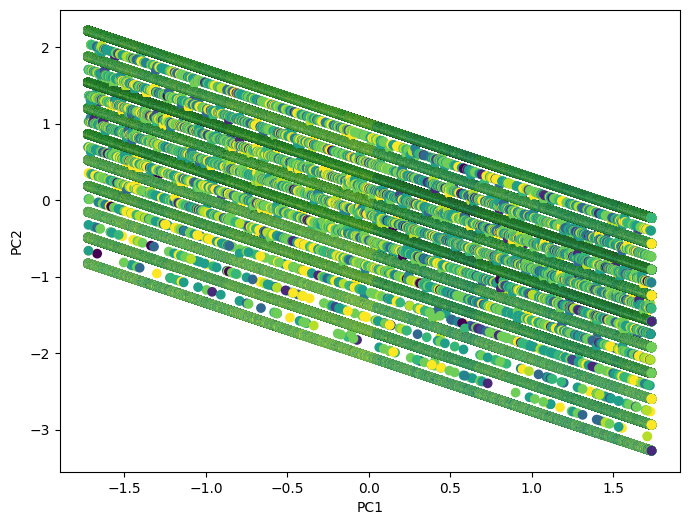

In [72]:
plt.figure(figsize=(8, 6))
plt.scatter(x=scaled_data[:, 0], y=pca_result[:, 1],c=data['rating_y'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()